In [1]:
from binomial_sampling import BinomialBandit
from datetime import timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
headached_from_coffee = BinomialBandit([0, 1, 2, 3, 4], minimize=True)

In [3]:
# 1 - болит голова
# 0 - не болит голова
# первое число - количество чашек кофе
events = {
datetime(2025, 4,12): (2, 0),
datetime(2025, 4,13): (2, 1),
datetime(2025, 4,14): (2, 0),
datetime(2025, 4,15): (2, 0),
datetime(2025, 4,16): (3, 0),
datetime(2025, 4,17): (2, 0),
datetime(2025, 4,18): (3, 1),
datetime(2025, 4,19): (2, 0),
datetime(2025, 4,20): (1, 0),
datetime(2025, 4,21): (4, 0),
datetime(2025, 4,22): (1, 0),
datetime(2025, 4,23): (2, 1),
datetime(2025, 4,24): (2, 0),
datetime(2025, 4,25): (1, 1),
datetime(2025, 4,26): (2, 0),
datetime(2025, 4,27): (2, 0),
datetime(2025, 4,28): (4, 0),
datetime(2025, 4,29): (4, 0),
datetime(2025, 4,30): (0, 1),
datetime(2025, 5, 1): (4, 1),
datetime(2025, 5, 2): (0, 0),
datetime(2025, 5, 3): (2, 1),
datetime(2025, 5, 4): (2, 0),
datetime(2025, 5, 5): (2, 1),
datetime(2025, 5, 6): (4, 1),
datetime(2025, 5, 7): (1, 0)

}


In [4]:
headached_from_coffee.process_events(events, days=365)

,name,alpha,beta,runs,theta_sample
2,2,5.0,10.0,13,0.251934
4,4,3.0,4.0,5,0.364853
1,1,2.0,4.0,4,0.551724
0,0,2.0,2.0,2,0.641351
3,3,2.0,2.0,2,0.926105


100%|██████████| 10000/10000 [00:05<00:00, 1920.75it/s]


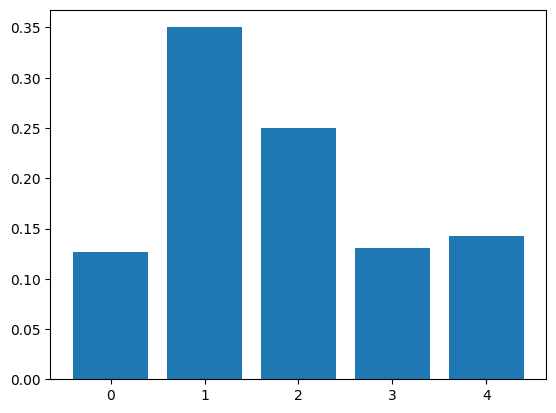

,variant,prob
3,0.0,0.1263
2,1.0,0.3502
0,2.0,0.2501
1,3.0,0.1305
4,4.0,0.1429


In [5]:
from collections import defaultdict
from tqdm import tqdm


results = defaultdict(int)
for i in tqdm(range(10000)):
    i_res = headached_from_coffee.grade()
    i_var = i_res.iloc[0]['name']
    results[i_var] += 1

variants_proba_current = pd.DataFrame(results.items(), columns=['variant', 'prob'])
variants_proba_current['prob'] = variants_proba_current['prob']/sum(variants_proba_current['prob'])
variants_proba_current = variants_proba_current.sort_values('variant')

plt.bar(variants_proba_current['variant'], variants_proba_current['prob'], align='center')

plt.show()
variants_proba_current

In [6]:
headached_from_coffee.history

,option,reward
0,2,0
1,2,1
2,2,0
3,2,0
4,3,0
5,2,0
6,3,1
7,2,0
8,1,0
9,4,0


In [7]:
grouped_data = {name: group['reward'].values for name, group in headached_from_coffee.history.groupby('option')}
grouped_data

{0: array([1, 0]),
 1: array([0, 0, 1, 0]),
 2: array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]),
 3: array([0, 1]),
 4: array([0, 0, 0, 1, 1])}

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def binomial_confidence(values, confidence=0.95):
    """
    Compute the binomial proportion confidence interval for a list of binary values (0/1).

    Parameters:
        values (list of int): A list consisting of 0s and 1s.
        confidence (float): The desired confidence level between 0 and 1 (default is 0.95).

    Returns:
        (lower_bound, upper_bound): The lower and upper bounds of the confidence interval.

    Raises:
        ValueError: If the input list is empty.
    """
    n = len(values)
    if n == 0:
        raise ValueError("The input list is empty.")
    
    successes = sum(values)
    lower_bound = beta.ppf((1 - confidence) / 2, successes + 1, n - successes + 1)
    upper_bound = beta.ppf(1 - (1 - confidence) / 2, successes + 1, n - successes + 1)
    return lower_bound, upper_bound

def compute_group_statistics(grouped_data, confidence=0.95):
    """
    Given a dictionary of grouped binary data, compute the mean (i.e. proportion) for each group along
    with the lower and upper bounds of the confidence interval using a binomial model.

    Parameters:
        grouped_data (dict): Keys are group labels and values are arrays/lists of binary values (0/1).
        confidence (float): The desired confidence level (default is 0.95).

    Returns:
        group_keys (list): Sorted list of group labels.
        means (list): List of computed mean proportions for each group.
        lower_bounds (list): Lower bounds of the confidence interval for each group.
        upper_bounds (list): Upper bounds of the confidence interval for each group.
    """
    group_keys = []
    means = []
    lower_bounds = []
    upper_bounds = []
    for key, values in grouped_data.items():
        group_keys.append(key)
        values_list = list(values)  # ensure it's a list
        means.append(np.mean(values_list))
        lb, ub = binomial_confidence(values_list, confidence)
        lower_bounds.append(lb)
        upper_bounds.append(ub)
    
    # Optional: sort by group key if desired
    sorted_indices = np.argsort(group_keys)
    group_keys = np.array(group_keys)[sorted_indices]
    means = np.array(means)[sorted_indices]
    lower_bounds = np.array(lower_bounds)[sorted_indices]
    upper_bounds = np.array(upper_bounds)[sorted_indices]
    
    return group_keys, means, lower_bounds, upper_bounds

def plot_group_statistics(group_keys, means, lower_bounds, upper_bounds):
    """
    Plot a bar chart with error bars for the provided group statistics.

    Parameters:
        group_keys (list): Group labels.
        means (list): Mean values.
        lower_bounds (list): Lower confidence bounds.
        upper_bounds (list): Upper confidence bounds.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    x = np.arange(len(group_keys))
    # Ensure that error values are non-negative.
    err_lower = np.clip(means - lower_bounds, a_min=0, a_max=None)
    err_upper = np.clip(upper_bounds - means, a_min=0, a_max=None)

    fig, ax = plt.subplots()
    ax.bar(x, means, 
           yerr=[err_lower, err_upper], 
           capsize=5, alpha=0.7, color='b')

    ax.set_xticks(x)
    ax.set_xticklabels(group_keys)
    ax.set_xlabel('Group')
    ax.set_ylabel('Probability with Confidence Bounds')
    ax.set_title('Grouped Data with Confidence Bounds')
    plt.show()

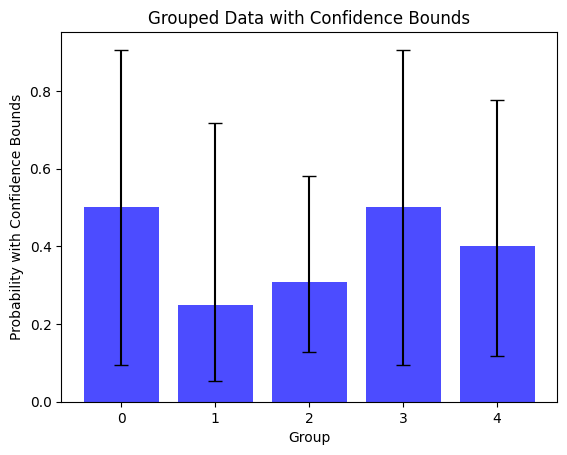

In [9]:
grouped_data = {name: group['reward'].values for name, group in headached_from_coffee.history.groupby('option')}

# Compute statistics for each group
group_keys, means, lower_bounds, upper_bounds = compute_group_statistics(grouped_data, confidence=0.95)

# Plot the results
plot_group_statistics(group_keys, means, lower_bounds, upper_bounds)